# 1 Setup

# 1.1 Read Packages

In [237]:
import pandas as pd
import numpy as np

from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split
from scipy import sparse, linalg

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# 1.2 Read Data

In [205]:
df = pd.read_csv('UMW_FR_reduced.csv', index_col=0)
df_tags = pd.read_csv('tags_clean.csv', index_col=0)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,20,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# 2 Data Preprocessing

# 2.1 Build Matrix A
**We still have not used the full A yet!**

In [206]:
#Drop na and duplicate rows
A = df[['user_id', 'mama_movie_id']].dropna()
A = A.drop_duplicates()
A['mama_movie_id'] = A['mama_movie_id'].astype(int)

In [207]:
#Limit the number of rows
A = A[:300000]

#Create the sparse matrix
A['count'] = 1
A = A.pivot(index='user_id', columns='mama_movie_id', values='count')
A = A.fillna(0)
A = sparse.coo_matrix(A.values)

In [208]:
#Create the sparse matrix
M = df_tags
M = sparse.coo_matrix(M.values)

# 2.2 Facts About A

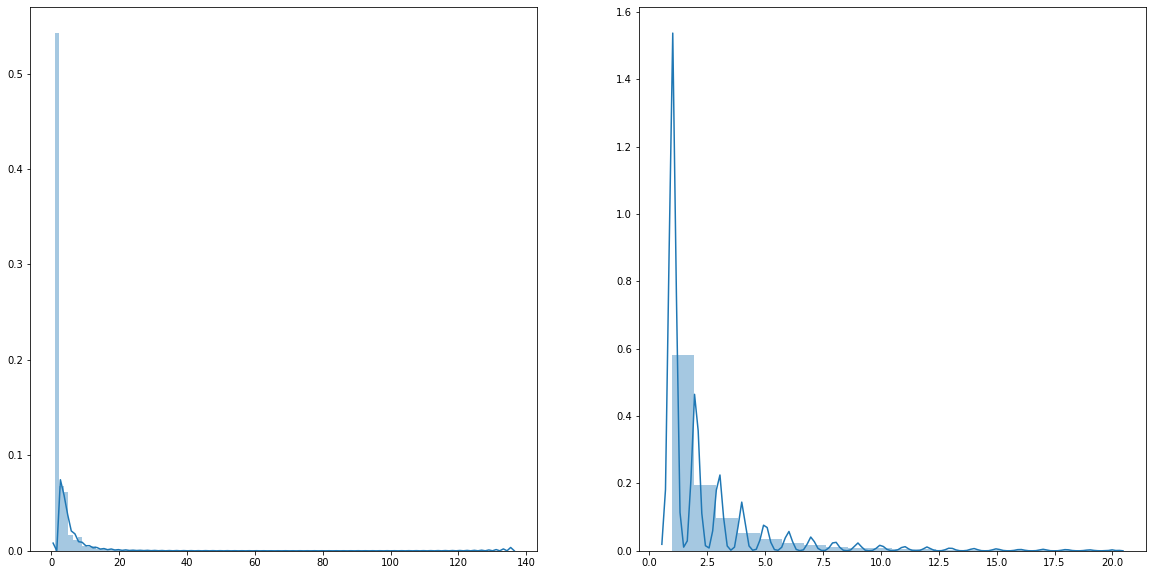

In [213]:
data = np.sum(A, axis=1)
fig, axes = plt.subplots(ncols=2, figsize=[20,10])

#The distribution of the number of movies watched by each user
g = sns.distplot(data, bins=100, ax=axes[0])
#The distribution of the number of movies watched by each user (with X limited to 0-20)
g = sns.distplot(data[data<=20], bins=20, ax=axes[1])

# 3 Collabrative Filtering

# 3.1 Modeling

In [214]:
model = LightFM(loss='warp', no_components=10)

# 3.2 Cross Validation

In [215]:
train, test = random_train_test_split(A, test_percentage=0.2, random_state=None)

In [216]:
model.fit(train, epochs=300, num_threads=8)

In [217]:
train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()
print('train_auc: ', train_auc)
print('test_auc: ', test_auc)

train_auc:  0.9962769
test_auc:  0.88036114


In [218]:
#Precision measures, if you select k movies for each customer in the test set, 
#the number of correctedly identified movies / k

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()
print('train_precision: ', train_precision)
print('test_precision: ', test_precision)

train_precision:  0.15660082
test_precision:  0.029837908


In [219]:
#Recall measures, if you select k movies for each customer in the test set, 
#the number of correctedly identified movies / the number of movies that a customer has watched

train_recall = recall_at_k(model, train, k=10).mean()
test_recall = recall_at_k(model, test, k=10).mean()
print('train_recall: ', train_recall)
print('test_recall: ', test_recall)

train_recall:  0.8909465719625106
test_recall:  0.22016766944476515


# 3.3 Model Training

In [220]:
model.fit(train, epochs=300, num_threads=8)

# 3.4 Customer Vectors and Movie Vectors

In [221]:
C_b, C = model.get_user_representations()
M_b, M = model.get_item_representations()

# 3.5 Predictions

In [222]:
pred = model.predict([0],[55])
pred

array([1.27762496])

# 4 Customer Clustering

# 4.1 Modeling

In [229]:
model = KMeans(n_clusters=3, random_state=0)
model.fit(C)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

# 4.2 Predictions

In [230]:
model.predict(C)

array([2, 0, 2, ..., 0, 0, 0])

# 5 Movie Clustering

# 5.1 Modeling

In [231]:
model = KMeans(n_clusters=3, random_state=0)
model.fit(M)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

# 5.2 Predictions

In [245]:
model.predict(M)

array([1, 1, 1, ..., 2, 0, 0])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002652CA519C8>,
      dtype=object)

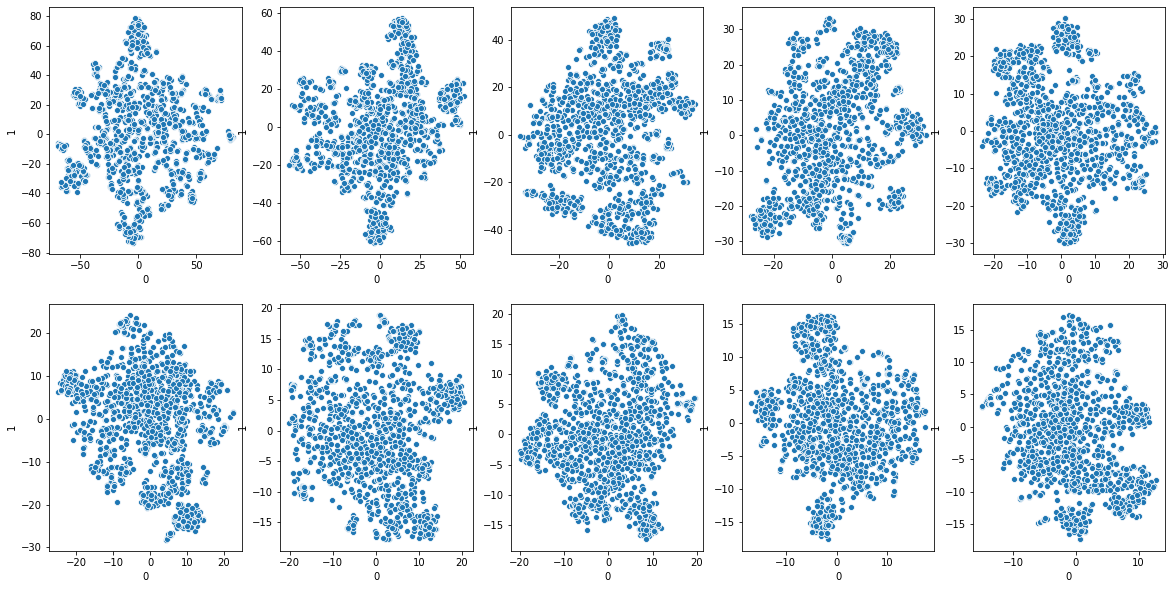

In [266]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=[20,10])
axes = axes.ravel()

for i in range(1, 11):
    Tsne = TSNE(n_components=2, perplexity=i * 10, random_state=0)
    M_2d = Tsne.fit_transform(M)
    M_2d = pd.DataFrame(M_2d)
    sns.scatterplot(x=0, y=1, data=M_2d, ax = axes[i-1])